### Importación de librerías

In [10]:
import os
import cv2
import numpy as np
import pickle
import mediapipe as mp
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Definición de variables

In [11]:
DATASET_PATH = "../../dataset/gestos_cara"
MODEL_FILE = "modelo_facial_red_augmentation.pkl"
CONFUSION_MATRIX_FILE = "confusion_matrix/matrix_confusion_facial.png"

### Lógica de entreno


 PASO 1: AUDITORÍA DEL DATASET (CARA)
Carpeta '0_Neutro': 350 válidas / 350 total.
Carpeta '1_Ojos_Cerrados': 363 válidas / 368 total.
Carpeta '2_Cabeza_Der': 428 válidas / 541 total.
Carpeta '3_Cabeza_Izq': 265 válidas / 410 total.

PASO 2: ENTRENAMIENTO (+ DATA AUGMENTATION)
Procesando '0_Neutro'...
   -> 1400 vectores generados.
Procesando '1_Ojos_Cerrados'...
   -> 1452 vectores generados.
Procesando '2_Cabeza_Der'...
   -> 1712 vectores generados.
Procesando '3_Cabeza_Izq'...
   -> 1060 vectores generados.

[INFO] Evaluando modelo y generando matriz de confusión...


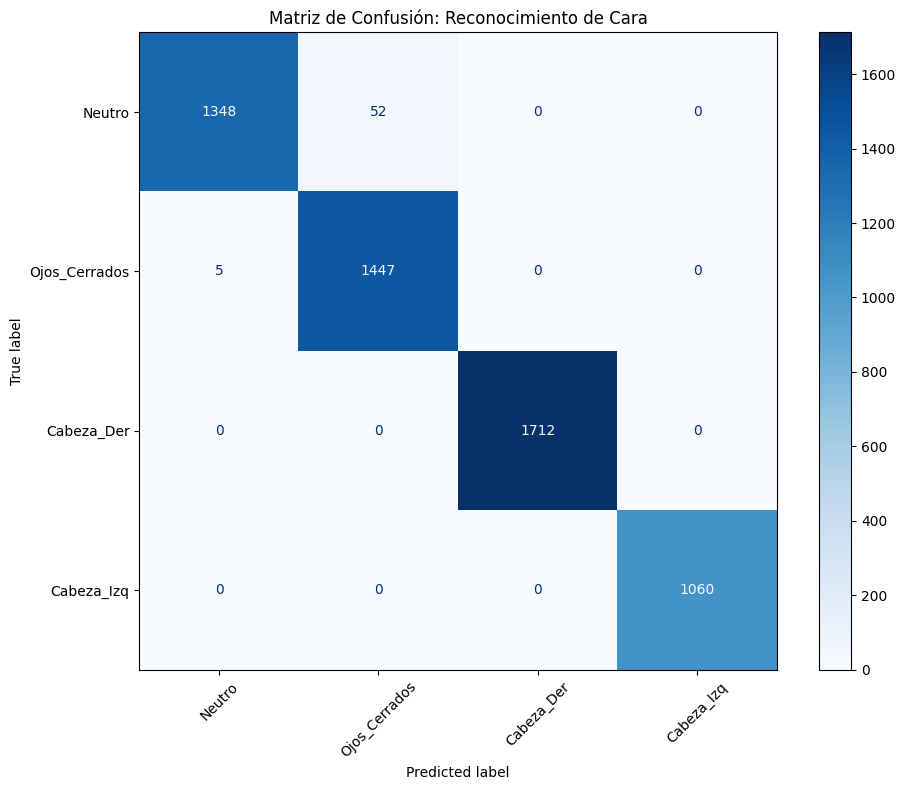


Precisión estimada (CV): 98.99%
Entrenando modelo final...
¡ÉXITO! Modelo guardado en: modelo_facial_red_augmentation.pkl


In [12]:
MAPA_ETIQUETAS = {
    "0_Neutro": 0,
    "1_Ojos_Cerrados": 1,
    "2_Cabeza_Der": 2,
    "3_Cabeza_Izq": 3
}

# --- CONFIGURACIÓN MEDIAPIPE ---
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

# ==========================================
#           FUNCIONES AUXILIARES
# ==========================================
def normalizar_puntos(landmarks):
    """Centra y escala los puntos de la mano."""
    coords = np.array([[lm.x, lm.y] for lm in landmarks])
    
    # 1. Centrar
    centroid = np.mean(coords, axis=0)
    centered = coords - centroid
    
    # 2. Escalar
    max_dist = np.max(np.abs(centered))
    if max_dist > 0:
        normalized = centered / max_dist
    else:
        normalized = centered
        
    return normalized.flatten()

def aumentar_datos(vector_original):
    """Genera variaciones: Ruido, Escala y Rotación."""
    variaciones = []
    variaciones.append(vector_original)
    
    puntos_2d = vector_original.reshape(-1, 2)

    # 1. Ruido ligero
    ruido = np.random.normal(0, 0.01, puntos_2d.shape)
    variaciones.append((puntos_2d + ruido).flatten())

    # 2. Escala (Zoom in/out leve)
    factor_escala = np.random.uniform(0.95, 1.05)
    variaciones.append((puntos_2d * factor_escala).flatten())
    
    # 3. Rotación (+/- 15 grados)
    theta = np.radians(np.random.uniform(-15, 15))
    c, s = np.cos(theta), np.sin(theta)
    matriz_rotacion = np.array(((c, -s), (s, c)))
    puntos_rotados = np.dot(puntos_2d, matriz_rotacion)
    variaciones.append(puntos_rotados.flatten())

    return variaciones

def mostrar_evaluacion_matriz(model, data, labels, kfold):
    """Genera, guarda y muestra la matriz de confusión."""
    print("\n[INFO] Evaluando modelo y generando matriz de confusión...")
    
    # Obtener predicciones mediante validación cruzada
    y_pred = cross_val_predict(model, data, labels, cv=kfold)
    
    # Calcular matriz
    cm = confusion_matrix(labels, y_pred)
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    nombres_clases = [n.split("_", 1)[-1] for n in MAPA_ETIQUETAS.keys()]
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nombres_clases)
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    
    plt.title("Matriz de Confusión: Reconocimiento de Cara")
    plt.tight_layout()
    
    plt.savefig(CONFUSION_MATRIX_FILE)
    plt.show()

# ==========================================
#           PASO 1: AUDITORÍA
# ==========================================
def auditar_dataset():
    print(f"\n{'='*40}")
    print(f" PASO 1: AUDITORÍA DEL DATASET (CARA)")
    print(f"{'='*40}")
    
    if not os.path.exists(DATASET_PATH):
        print(f"ERROR CRÍTICO: La ruta '{DATASET_PATH}' no existe.")
        return False

    total_global_ok = 0
    archivos_fallidos = []

    for carpeta in MAPA_ETIQUETAS.keys():
        ruta_carpeta = os.path.join(DATASET_PATH, carpeta)
        if not os.path.exists(ruta_carpeta): continue
        
        imagenes = [f for f in os.listdir(ruta_carpeta) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        count_ok = 0

        for archivo in imagenes:
            img = cv2.imread(os.path.join(ruta_carpeta, archivo))
            if img is None: continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(img_rgb)

            if results.multi_face_landmarks:
                count_ok += 1
            else:
                archivos_fallidos.append(os.path.join(carpeta, archivo))

        print(f"Carpeta '{carpeta}': {count_ok} válidas / {len(imagenes)} total.")
        total_global_ok += count_ok

    return total_global_ok > 0

# ==========================================
#            PASO 2: ENTRENAMIENTO
# ==========================================
def entrenar_modelo():
    print(f"\n{'='*40}")
    print(f"PASO 2: ENTRENAMIENTO (+ DATA AUGMENTATION)")
    print(f"{'='*40}")

    data = []
    labels = []

    for nombre_carpeta, etiqueta_num in MAPA_ETIQUETAS.items():
        ruta_carpeta = os.path.join(DATASET_PATH, nombre_carpeta)
        if not os.path.exists(ruta_carpeta): continue
        
        print(f"Procesando '{nombre_carpeta}'...")
        muestras_clase = 0
        
        for archivo in os.listdir(ruta_carpeta):
            if not archivo.lower().endswith(('.jpg', '.png', '.jpeg')): continue
            
            img = cv2.imread(os.path.join(ruta_carpeta, archivo))
            if img is None: continue
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(img_rgb)
            
            if results.multi_face_landmarks:
                vector_base = normalizar_puntos(results.multi_face_landmarks[0].landmark)
                vectores_aumentados = aumentar_datos(vector_base)
                
                for v in vectores_aumentados:
                    data.append(v)
                    labels.append(etiqueta_num)
                    muestras_clase += 1
        
        print(f"   -> {muestras_clase} vectores generados.")

    data, labels = np.array(data), np.array(labels)
    if len(data) == 0: return

    # Configuración del modelo
    model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1500, random_state=42)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 1. EVALUACIÓN Y MATRIZ
    mostrar_evaluacion_matriz(model, data, labels, kfold)
    
    # 2. MÉTRICAS
    scores = cross_val_score(model, data, labels, cv=kfold)
    print(f"\nPrecisión estimada (CV): {scores.mean() * 100:.2f}%")

    # 3. ENTRENAMIENTO FINAL Y GUARDADO
    print("Entrenando modelo final...")
    model.fit(data, labels)
    
    with open(MODEL_FILE, 'wb') as f:
        pickle.dump(model, f)
    print(f"¡ÉXITO! Modelo guardado en: {MODEL_FILE}")

# ==========================================
#           EJECUCIÓN PRINCIPAL
# ==========================================
if __name__ == "__main__":
    if auditar_dataset():
        entrenar_modelo()